In [44]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation

import tensorflow as tf

import params
import dataset

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def BuildModel():
    inp = Input(shape=(params.GetImageSize(), params.GetImageSize(), params.GetChannelsNum()))

    conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
    conv_1_1 = Activation('relu')(conv_1_1)
    conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
    conv_1_2 = Activation('relu')(conv_1_2)
    pool_1 = MaxPooling2D(2)(conv_1_2)

    conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
    conv_2_1 = Activation('relu')(conv_2_1)
    conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
    conv_2_2 = Activation('relu')(conv_2_2)
    pool_2 = MaxPooling2D(2)(conv_2_2)

    conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
    conv_3_1 = Activation('relu')(conv_3_1)
    conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
    conv_3_2 = Activation('relu')(conv_3_2)
    pool_3 = MaxPooling2D(2)(conv_3_2)

    up_1 = UpSampling2D(2, interpolation='bilinear')(pool_3)
    conc_1 = Concatenate()([conv_3_2, up_1])
    conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(up_1)
    conv_up_1_1 = Activation('relu')(conv_up_1_1)
    conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
    conv_up_1_2 = Activation('relu')(conv_up_1_2)

    up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
    conc_2 = Concatenate()([conv_2_2, up_2])
    conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(up_2)
    conv_up_2_1 = Activation('relu')(conv_up_2_1)
    conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
    conv_up_2_2 = Activation('relu')(conv_up_2_2)

    up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
    conc_3 = Concatenate()([conv_1_2, up_3])
    conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(up_3)
    conv_up_3_1 = Activation('relu')(conv_up_3_1)
    conv_up_3_2 = Conv2D(4, (3, 3), padding='same')(conv_up_3_1)
    result = Activation('sigmoid')(conv_up_3_2)
    
    return Model(inputs=inp, outputs=result)

model = BuildModel()

In [3]:
best_w = keras.callbacks.ModelCheckpoint('unet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('unet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'categorical_crossentropy')

In [4]:
data = dataset.read_train_validation_big_sets(
        train_path = os.path.join(params.training_data_path),
        validation_path = os.path.join(params.validation_data_path),
        image_size = params.GetImageSize())

print("Complete reading input data. Will Now print a snippet of it")
print("Number of files in Training-set:\t\t{}".format(data.train.num_examples))
print("Number of files in Validation-set:\t{}".format(data.valid.num_examples))

Complete reading input data. Will Now print a snippet of it
Number of files in Training-set:		100
Number of files in Validation-set:	20


In [5]:
img_df = data.train.image_paths
mask_df = data.train.masks_paths
batch_size = 26

index = 0
while index < 5:
    x_batch = []
    y_batch = []
    r_batch = []

    for i in range(batch_size):
        img_name = img_df[index]
        mask_name = mask_df[index]

#             print(index, img_name, mask_name)

        index = (index + 1) % len(img_df)

        img = cv2.imread(img_name, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)

#             img, mask

        img = cv2.resize(img, (params.GetImageSize(), params.GetImageSize()))
        mask = cv2.resize(mask, (params.GetImageSize(), params.GetImageSize()))            

        height, width = mask.shape
        masks = np.zeros((height, width, 4))
        for i in range(masks.shape[2]):
            masks[:, :, i] = (mask == (i+1))

        #moving the channel:
        mask_train = np.moveaxis(masks,-1,1)

        x_batch += [img]
        y_batch.append(mask_train)
        r_batch += [mask]

    x_batch = np.array(x_batch) / 255.
    y_batch = np.array(y_batch) / 255.
    r_batch = np.array(r_batch) / 255.

In [6]:
x_batch.shape,y_batch.shape,r_batch.shape

((26, 128, 128, 3), (26, 128, 4, 128), (26, 128, 128))

In [19]:
def keras_generator(img_df, mask_df, batch_size):
    index = 0
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name = img_df[index]
            mask_name = mask_df[index]
            
#             print(index, img_name, mask_name)
            
            index = (index + 1) % len(img_df)
            
            img = cv2.imread(img_name, cv2.IMREAD_COLOR)
            mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
            
#             img, mask
            
            img = cv2.resize(img, (params.GetImageSize(), params.GetImageSize()))
            mask = cv2.resize(mask, (params.GetImageSize(), params.GetImageSize()))            
            
            height, width = mask.shape
            masks = np.zeros((height, width, 4))
            for i in range(masks.shape[2]):
                masks[:, :, i] = (mask == (i+1))
            
#             masks = np.moveaxis(masks,-1,1)
            
            x_batch += [img]
            y_batch.append(masks)

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch) / 255.
        
#         print(x_batch.shape,y_batch.shape)

        yield x_batch, y_batch

In [20]:
batch_size = 16
model.fit_generator(keras_generator(data.train.image_paths, data.train.masks_paths, batch_size),
              steps_per_epoch=100,
              epochs=3,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(data.valid.image_paths, data.valid.masks_paths, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=True,
              shuffle=True,
              initial_epoch=0)

Epoch 1/3
100/100 [==============================] - 689s 7s/step - loss: 0.0024 - val_loss: 0.0021
Epoch 2/3
100/100 [==============================] - 727s 7s/step - loss: 0.0012 - val_loss: 7.6160e-04
Epoch 3/3
100/100 [==============================] - 741s 7s/step - loss: 8.3080e-04 - val_loss: 6.8672e-04


In [21]:
from keras.models import load_model

model1 = BuildModel()
model1.load_weights('unet_best.h5')
# model1 = load_model('unet_best.h5')

In [22]:
for x, y in keras_generator(data.train.image_paths, data.train.masks_paths, 16):
    break

In [23]:
pred = model1.predict(x)

In [46]:
pred[0].shape

(128, 128, 4)

In [66]:
keras.backend.eval(tf.keras.backend.argmax(pred[sample_index], 2)).shape

(128, 128)

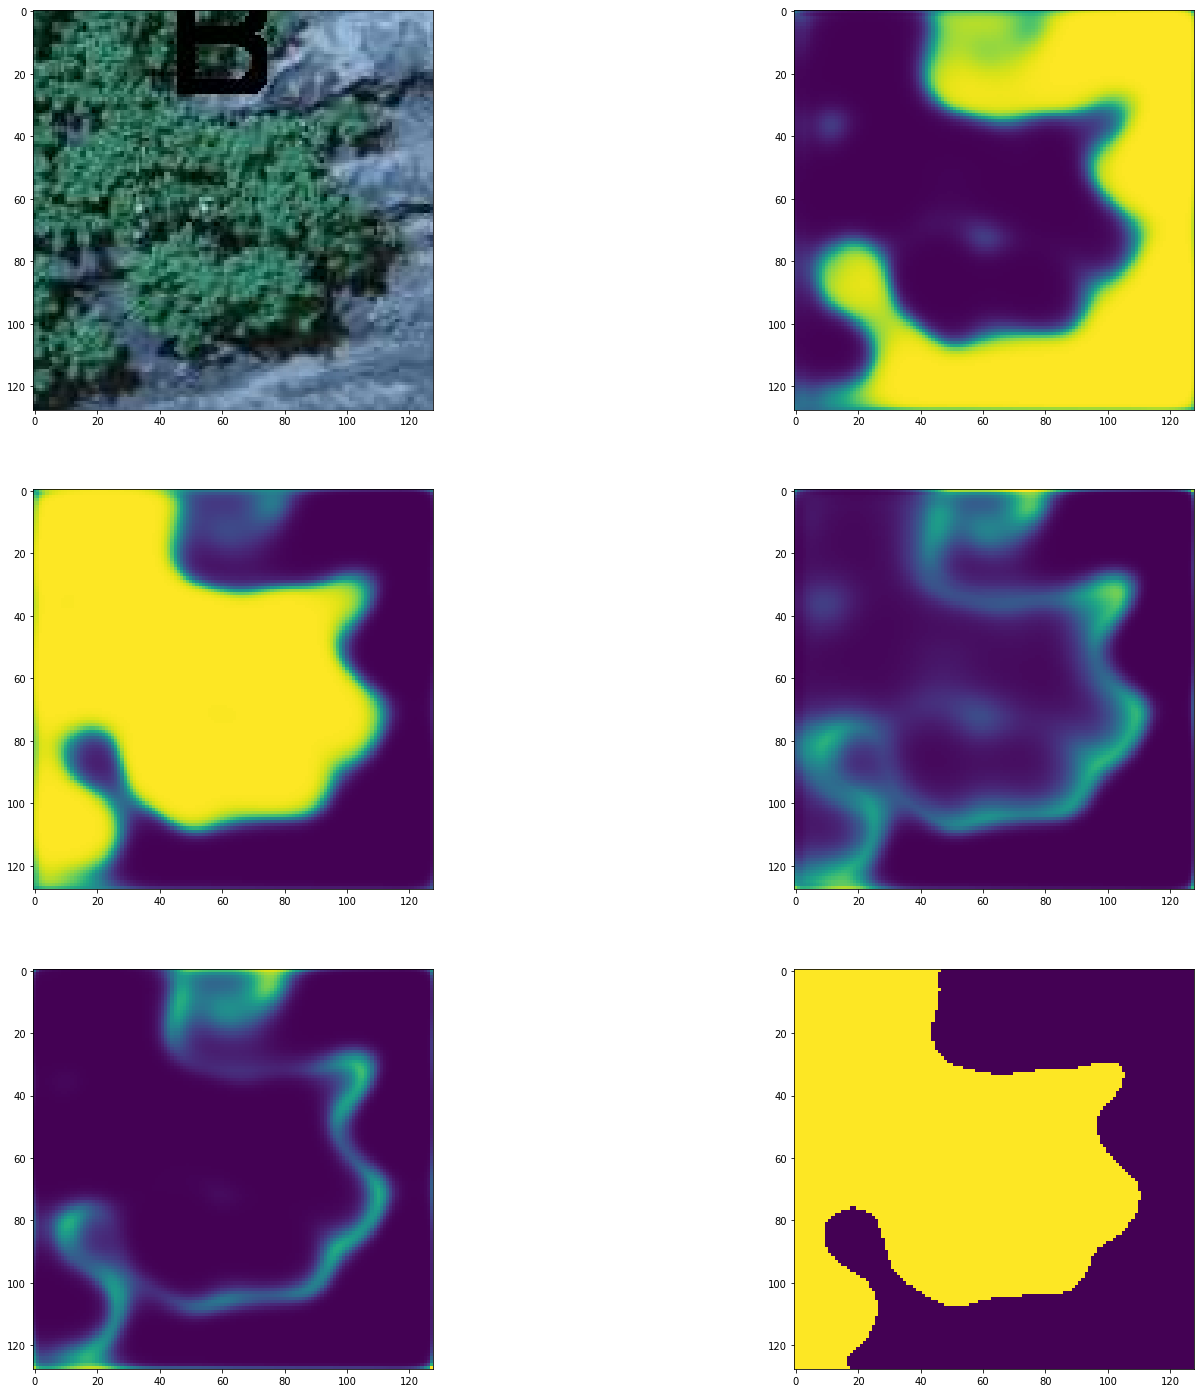

In [73]:
sample_index = 1
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(25, 25))
axes[0][0].imshow(x[sample_index])
axes[0][1].imshow(pred[sample_index, ..., 0])
axes[1][0].imshow(pred[sample_index, ..., 1])
axes[1][1].imshow(pred[sample_index, ..., 2])
axes[2][0].imshow(pred[sample_index, ..., 3])
axes[2][1].imshow(keras.backend.eval(tf.keras.backend.argmax(pred[sample_index], 2)).astype(np.float32)*40)

plt.show()